## Introducción
Esta serie de tiempo corresponde a una sección de mi proyecto de Profundizacion titulado **"Dinámica de los Servicios de Salud en Barranquilla: Un Estudio Integrado de Demanda, Accesibilidad y Duración de la Hospitalización"**. El objetivo principal de este proyecto es analizar en profundidad los patrones y tendencias en la demanda de servicios de salud en la ciudad de Barranquilla, Colombia, utilizando técnicas avanzadas de análisis de datos y visualización.

En particular, esta sección se enfoca en el Análisis de la Demanda de Servicios, donde se aplican métodos estadísticos y herramientas de programación en Python para descomponer series de tiempo y comprender mejor los componentes subyacentes que afectan la demanda de atención médica en los diferentes centros de salud de la ciudad.

El análisis completo y detallado del proyecto, incluyendo el Análisis Exploratorio de Datos (EDA), puede consultarse en el siguiente enlace:
https://rpubs.com/reyesjj/eda_v2

## Importación de Librerías y Conexión a la Base de Datos
Comenzamos importando las librerías necesarias para el análisis y estableciendo la conexión con la base de datos `PostgreSQL` donde se almacenan los datos.

In [1]:
# Importar las librerías necesarias
import plotly.io as pio
pio.renderers.default = 'plotly_mimetype'
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import plotly.express as px
import plotly.graph_objects as go
import folium
from folium import plugins
import branca.colormap as cm
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.subplots as sp
import matplotlib.dates as mdates


In [2]:
# Credenciales para la base de datos
db = 'proyecto_uninorte'
host = 'localhost'
port = '5432'
user = 'user_db'
pswd = 'jota1991'

# Conectar a la base de datos
engine = create_engine(f'postgresql://{user}:{pswd}@{host}:{port}/{db}')

# Verificar la conexión
try:
    conn = engine.connect()
    print("Conexión exitosa a la base de datos.")
except Exception as e:
    print("Fallo en la conexión a la base de datos.")
    print(e)


Conexión exitosa a la base de datos.


La conexión se ha establecido correctamente, lo que nos permite acceder a los datos necesarios para el análisis.

## Análisis de la Demanda de Servicios
## Mapa de Atenciones por Centro de Salud
El primer paso es visualizar cómo se distribuyen las `atenciones médicas` en los diferentes centros de salud de Barranquilla. Para ello, realizaremos lo siguiente:
**Obtención del Número de Atenciones por Centro**
Extraemos de la base de datos el número total de atenciones realizadas en cada centro de salud, agrupándolos por su nombre y tipo

In [3]:
atenciones_por_centro = pd.read_csv('atenciones_por_centro.csv')


### Obtención de las Coordenadas de los Centros

Obtenemos las coordenadas geográficas (`latitud` y `longitud`) de cada centro de salud para poder representarlos en un mapa

In [4]:
# Obtener las coordenadas de los centros
coordenadas_centros = pd.read_csv('coordenadas_centros.csv')


# Unir los datos
datos_mapa = pd.merge(atenciones_por_centro, coordenadas_centros, on='nomb_pas_cam')


## Preparación de los Datos para el Mapa

Unimos los datos de atenciones con las coordenadas de los centros para tener toda la información necesaria en un solo DataFrame. y Para representar visualmente la cantidad de atenciones, utilizamos una paleta de colores y escalamos el tamaño de los marcadores en función del número de atenciones.

In [5]:
# Crear la paleta de colores
colormap = cm.linear.YlOrRd_09.scale(
    datos_mapa['total_atenciones'].min(),
    datos_mapa['total_atenciones'].max()
)
colormap = colormap.to_step(n=10)

# Función para escalar tamaños
def scale_size(x, min_size=5, max_size=15):
    x_scaled = (x - datos_mapa['total_atenciones'].min()) / (datos_mapa['total_atenciones'].max() - datos_mapa['total_atenciones'].min())
    return x_scaled * (max_size - min_size) + min_size

# Aplicar la función de escala
datos_mapa['size'] = datos_mapa['total_atenciones'].apply(scale_size)


## Mapa Interactivo

Utilizamos la librería `Folium` para crear un mapa interactivo que muestra la ubicación de los centros de salud y visualiza el número de atenciones mediante el tamaño y color de los marcadores.

In [6]:
# Crear el mapa centrado en Barranquilla
mapa = folium.Map(location=[10.96854, -74.78132], zoom_start=12)

# Añadir los marcadores al mapa
for idx, row in datos_mapa.iterrows():
    folium.CircleMarker(
        location=[row['latitud_cen_aten'], row['long_cen_aten']],
        radius=row['size'],
        color=colormap(row['total_atenciones']),
        fill=True,
        fill_color=colormap(row['total_atenciones']),
        fill_opacity=0.8,
        popup=folium.Popup(f"<strong>{row['nomb_pas_cam']}</strong><br>Tipo: {row['tipo_cen_aten']}<br>Atenciones: {row['total_atenciones']}", max_width=300)
    ).add_to(mapa)

# Añadir la leyenda al mapa
colormap.caption = 'Total de Atenciones'
colormap.add_to(mapa)

# Mostrar el mapa
mapa


El mapa interactivo nos permite visualizar la distribución geográfica de las atenciones médicas en Barranquilla. Observamos que:

1. Los centros de salud con mayor número de atenciones se representan con marcadores más grandes y colores más intensos.
2. Los Puntos de Atención en Salud Oportuna (`P.A.S.O.S.`), los Centros de Atención Médica Integral Oportuna (`C.A.M.I.N.O.S.`) y los `Hospitales` están distribuidos estratégicamente en la ciudad.
3. La concentración de atenciones es mayor en ciertas zonas, lo que podría indicar áreas con mayor demanda de servicios de salud.

## Análisis de los Diagnósticos Más Frecuentes
Identificamos los diagnósticos más comunes entre los pacientes atendidos.
**Extracción de los Diagnósticos Más Frecuentes**
Obtenemos los 20 diagnósticos con mayor número de atenciones.

In [7]:
# Obtener los 20 diagnósticos más frecuentes
top_diagnosticos = pd.read_csv('top_diagnosticos.csv')

top_diagnosticos.head()


,diagnostico,total_atenciones
0,Z000-EXAMEN MEDICO GENERAL,654993
1,Z001-CONTROL DE SALUD DE RUTINA DEL NINO,326785
2,Z012-EXAMEN ODONTOLOGICO,215738
3,K021-CARIES DE LA DENTINA,212620
4,I10X-HIPERTENSION ESENCIAL (PRIMARIA),173499


Creamos un gráfico de barras horizontal para visualizar los diagnósticos más frecuentes.

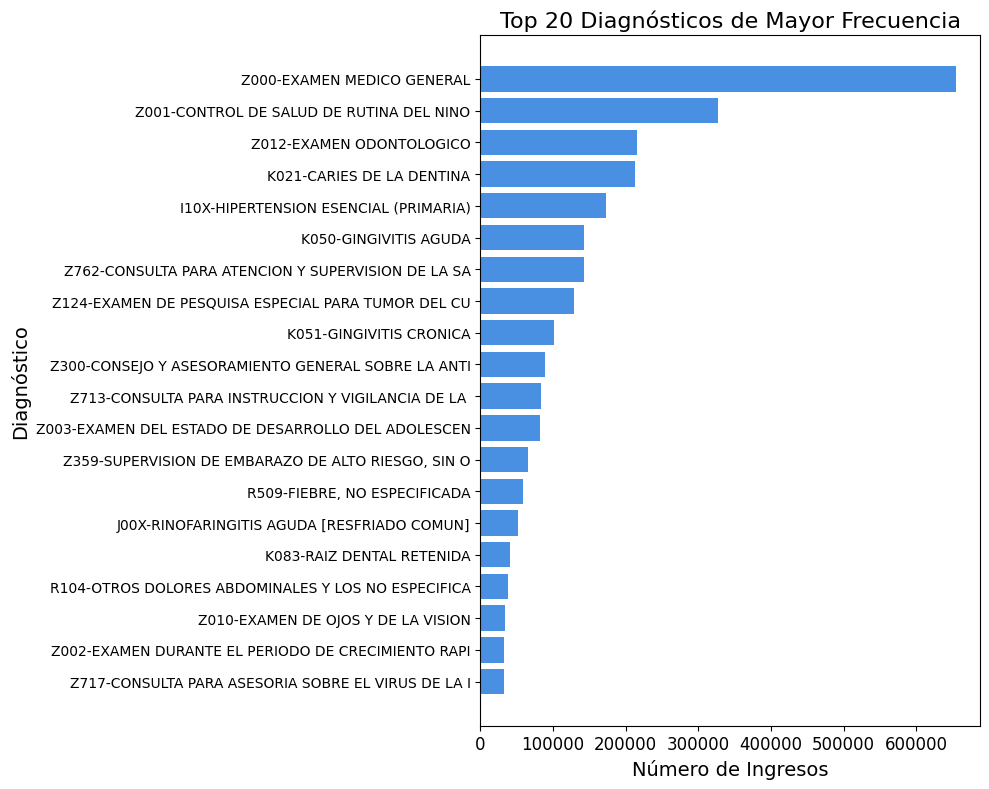

In [8]:
# Asegúrate de que el DataFrame tenga suficientes diagnósticos
top_20_diagnosticos = top_diagnosticos.sort_values('total_atenciones', ascending=True).head(20)

# Limitar los nombres de los diagnósticos a 50 caracteres
top_20_diagnosticos['diagnostico_truncado'] = top_20_diagnosticos['diagnostico'].str.slice(0, 50)

# Importar matplotlib
import matplotlib.pyplot as plt

# Configurar el tamaño de la figura
plt.figure(figsize=(10, 8))

# Crear el gráfico de barras horizontal estático
plt.barh(
    top_20_diagnosticos['diagnostico_truncado'],
    top_20_diagnosticos['total_atenciones'],
    color='#4A90E2'
)

# Personalizar el gráfico
plt.xlabel('Número de Ingresos', fontsize=14)
plt.ylabel('Diagnóstico', fontsize=14)
plt.title('Top 20 Diagnósticos de Mayor Frecuencia', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)

# Ajustar el layout para evitar cortes en los labels
plt.tight_layout()

# Mostrar el gráfico
plt.show()






 A partir de los resultados, podemos hacer las siguientes observaciones:

1. **Exámenes médicos generales y controles rutinarios**: 
   Los diagnósticos relacionados con exámenes médicos generales (`Z000`) y controles de salud rutinarios para niños (`Z001`) son los más frecuentes, superando las 600,000 atenciones.

2. **Problemas odontológicos**: 
   Diagnósticos como la `caries dental` (`K021`) y la `gingivitis` (`K050` y `K051`) ocupan un lugar destacado en el gráfico. Esto pone en evidencia la importancia de la atención en salud bucal en la población.

3. **Enfermedades crónicas**: 
   La `hipertensión esencial primaria` (`I10X`) se posiciona entre los diagnósticos más comunes, lo que subraya la relevancia de las enfermedades crónicas en la población atendida. 

4. **Condiciones relacionadas con la maternidad**: 
   Diagnósticos como la `supervisión de embarazo de alto riesgo` (`Z359`) también figuran entre los más frecuentes. Esto resalta la importancia de los servicios de salud materna y la atención especializada durante el embarazo.


## Evolución del Número de Atenciones por Semana
Analizamos cómo ha evolucionado el número de atenciones médicas a lo largo del tiempo, desde enero de 2022 hasta julio de 2024.

**Extracción de Datos**


In [9]:
# Obtener registros únicos de "ingreso" y las fechas de ingreso desde enero de 2022
data_unicos = pd.read_csv('data_unicos.csv')
data_unicos.head()


,ingreso,fecha_ingreso
0,15523392,2024-01-19
1,16140800,2024-04-03
2,16702501,2024-06-11
3,16371614,2024-04-27
4,9927366,2022-03-10


**Preparación de los Datos**

Convertimos las fechas al formato datetime y agrupamos las atenciones por semana.

In [10]:
# Convertir la fecha de ingreso al formato datetime
data_unicos['fecha_ingreso'] = pd.to_datetime(data_unicos['fecha_ingreso'])

# Obtener el inicio de la semana para cada fecha
data_unicos['semana_ingreso'] = data_unicos['fecha_ingreso'] - pd.to_timedelta(data_unicos['fecha_ingreso'].dt.weekday, unit='d')

# Agrupar por semana y contar el número de atenciones
serie_tiempo_atenciones = data_unicos.groupby('semana_ingreso').agg({'ingreso': 'count'}).reset_index()
serie_tiempo_atenciones.rename(columns={'ingreso': 'atenciones'}, inplace=True)



**Visualización de la Evolución de Atenciones**

Utilizamos `Plotly` para crear un gráfico interactivo que muestra la evolución semanal del número de atenciones.

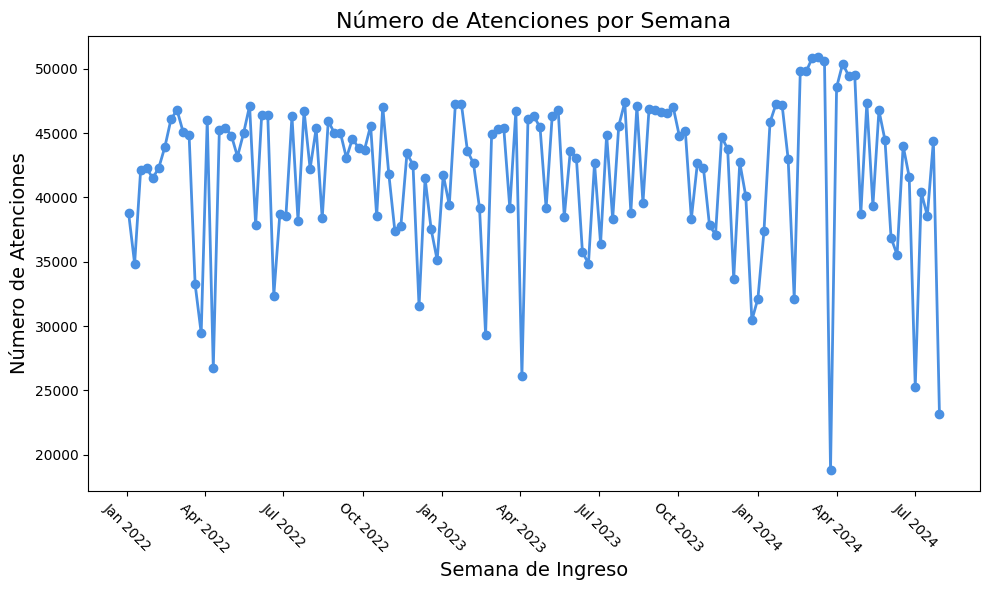

In [11]:
# Importar las bibliotecas necesarias
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Asegurarse de que 'semana_ingreso' sea de tipo datetime
serie_tiempo_atenciones['semana_ingreso'] = pd.to_datetime(serie_tiempo_atenciones['semana_ingreso'])

# Crear el gráfico de líneas
plt.figure(figsize=(10, 6))
plt.plot(
    serie_tiempo_atenciones['semana_ingreso'],
    serie_tiempo_atenciones['atenciones'],
    marker='o',
    color='#4A90E2',
    linewidth=2,
    markersize=6
)

# Establecer el formato de fecha en el eje x
date_formatter = mdates.DateFormatter('%b %Y')
plt.gca().xaxis.set_major_formatter(date_formatter)

# Rotar las etiquetas del eje x
plt.xticks(rotation=-45)

# Etiquetas y título
plt.xlabel('Semana de Ingreso', fontsize=14)
plt.ylabel('Número de Atenciones', fontsize=14)
plt.title('Número de Atenciones por Semana', fontsize=16)

# Ajustar los márgenes
plt.tight_layout()

# Mostrar el gráfico
plt.show()



Podemos hacer las siguientes observaciones:

1. **Fluctuaciones semanales**: Se observan variaciones considerables en la cantidad de atenciones por semana, lo que sugiere que la demanda de servicios de salud no es constante a lo largo del tiempo.

2. **Picos significativos**: En varias ocasiones, el número de atenciones alcanza niveles máximos que superan las 50,000 atenciones semanales. 

3. **Tendencia general**: A lo largo del período analizado, aunque las atenciones semanales fluctúan, el promedio general parece mantenerse entre las 40,000 y 45,000 atenciones. 

4. **Caídas abruptas**: También se observan caídas pronunciadas en algunas semanas, donde el número de atenciones baja significativamente. 


## Descomposición de la Serie Temporal

Utilizaremos el método de descomposición aditiva para separar la serie en sus componentes: tendencia, estacionalidad y residuo.

In [12]:
# Aplicar la descomposición estacional
decompose_result = seasonal_decompose(serie_tiempo_atenciones['atenciones'], model='additive', period=12)


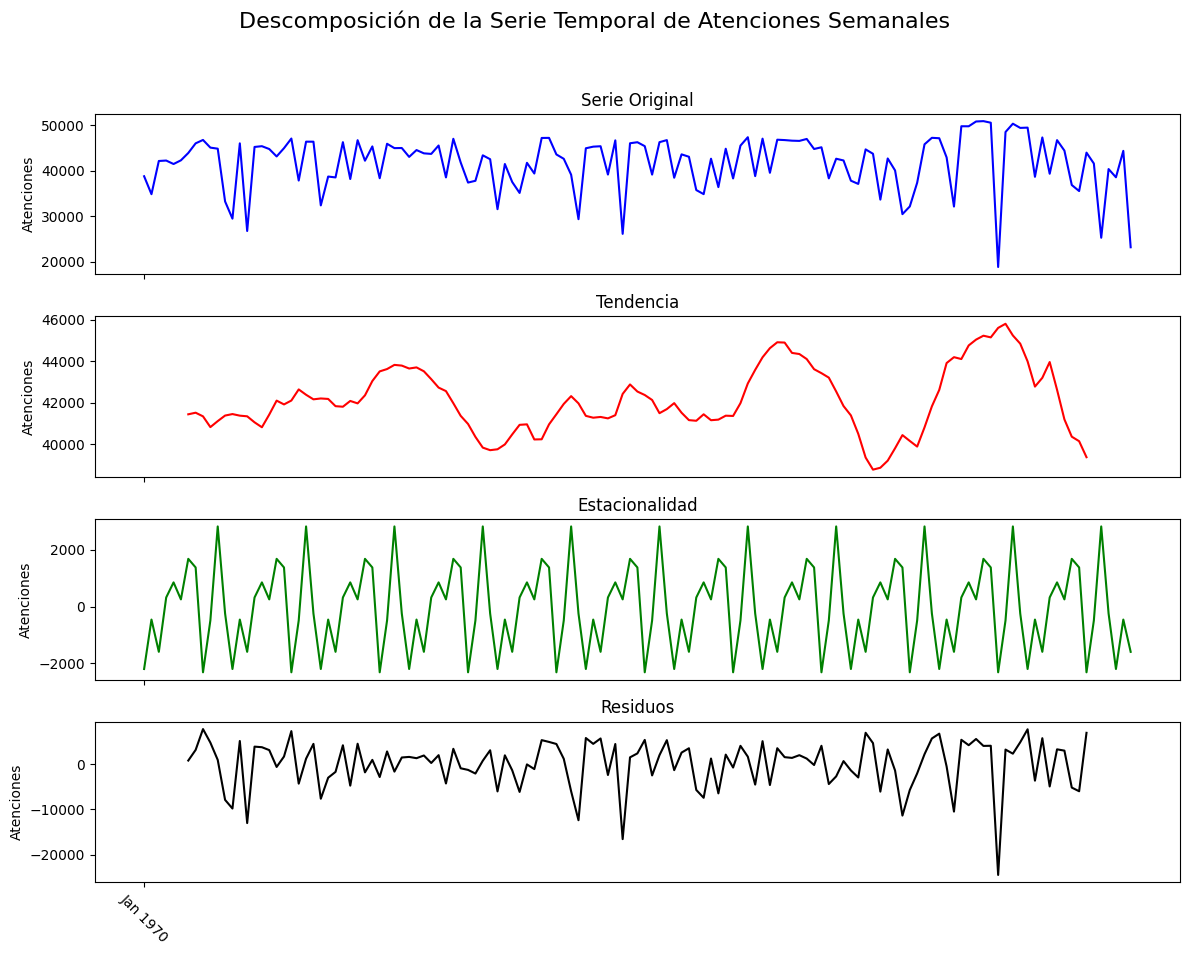

In [13]:

# Asegurarse de que 'serie_tiempo_atenciones' tenga un índice de tipo datetime
serie_tiempo_atenciones.index = pd.to_datetime(serie_tiempo_atenciones.index)

# Crear una figura con 4 subplots verticales que comparten el eje X
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Serie Original
axes[0].plot(serie_tiempo_atenciones.index, decompose_result.observed, color='blue')
axes[0].set_title('Serie Original')
axes[0].set_ylabel('Atenciones')

# Tendencia
axes[1].plot(serie_tiempo_atenciones.index, decompose_result.trend, color='red')
axes[1].set_title('Tendencia')
axes[1].set_ylabel('Atenciones')

# Estacionalidad
axes[2].plot(serie_tiempo_atenciones.index, decompose_result.seasonal, color='green')
axes[2].set_title('Estacionalidad')
axes[2].set_ylabel('Atenciones')

# Residuos
axes[3].plot(serie_tiempo_atenciones.index, decompose_result.resid, color='black')
axes[3].set_title('Residuos')
axes[3].set_ylabel('Atenciones')

# Formatear el eje X para mostrar fechas legibles
date_formatter = mdates.DateFormatter('%b %Y')
axes[3].xaxis.set_major_formatter(date_formatter)

# Rotar las etiquetas del eje X
plt.setp(axes[3].xaxis.get_majorticklabels(), rotation=-45)

# Establecer el título general de la figura
fig.suptitle('Descomposición de la Serie Temporal de Atenciones Semanales', fontsize=16)

# Ajustar los márgenes y espacios entre subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Mostrar el gráfico
plt.show()


### Interpretación de los Componentes de la Serie Temporal

#### Componente de Tendencia

- Se observa que la tendencia muestra un comportamiento **ligeramente ascendente** en ciertos periodos, lo que podría indicar un **aumento gradual** en la demanda de servicios de salud en algunas épocas. 
- Hay momentos donde la tendencia se mantiene **estable** o incluso **desciende**, lo que sugiere que la demanda de atenciones en salud pudo haberse visto influenciada por factores externos.

#### Componente Estacional


- Los patrones de **estacionalidad** parecen estar alineados con ciclos anuales, con picos y valles recurrentes que se **repiten aproximadamente cada 52 semanas**.

#### Componente Residual


- En este caso, los **residuos** muestran una distribución **sin patrones claros**, lo que indica que el modelo de descomposición captura de manera adecuada la tendencia y la estacionalidad.
- No obstante, algunas **fluctuaciones más pronunciadas** en ciertos momentos podrían señalar **anomalías o eventos inusuales** que afectaron la demanda, como pandemias, emergencias de salud pública o fallas en la infraestructura de salud.



## Evaluación de Estacionariedad

Utilizamos la prueba de `Dickey-Fuller` aumentada (`ADF`) para evaluar si la serie es estacionaria

In [14]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(serie_tiempo_atenciones['atenciones'])
print('Estadístico ADF:', result[0])
print('Valor p:', result[1])
print('Valores Críticos:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


Estadístico ADF: -10.806335964356952
Valor p: 1.9589904982321583e-19
Valores Críticos:
	1%: -3.480
	5%: -2.883
	10%: -2.578


El valor p obtenido (1.959e-19) es extremadamente bajo, mucho menor que cualquier nivel de significancia típico (como 0.01, 0.05 o 0.10). Además, el estadístico ADF (-10.806) es menor que todos los valores críticos en los diferentes niveles (1%, 5%, y 10%).

Por lo tanto, con base en estos resultados:

Rechazamos la hipótesis nula de que la serie temporal tiene una raíz unitaria, lo que significa que la serie es estacionaria.
No parece necesario aplicar diferenciación u otras transformaciones adicionales para estabilizar la media de la serie, ya que los resultados del test ADF indican que la serie no presenta problemas de no estacionariedad.

## Autocorrelación y Autocorrelación Parcial

Graficamos las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF) para identificar patrones en las dependencias temporales.

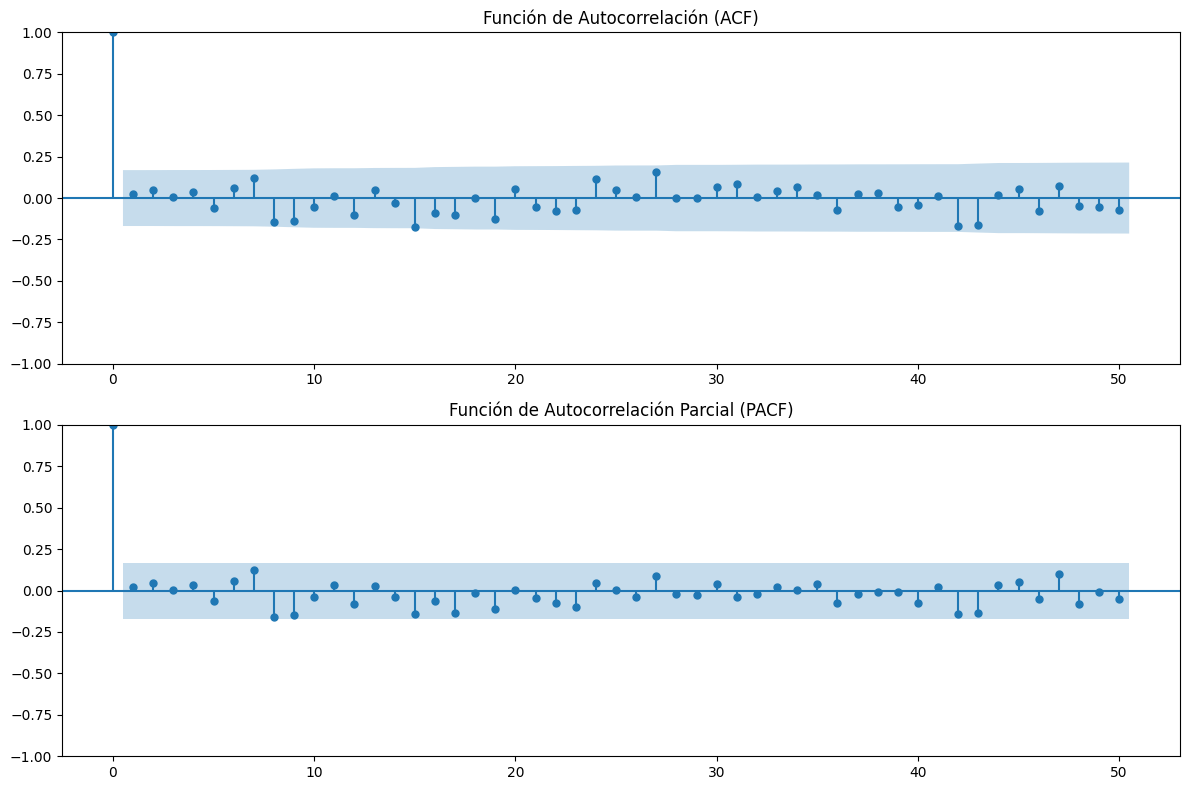

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12,8))

# ACF
plot_acf(serie_tiempo_atenciones['atenciones'], lags=50, ax=ax[0])
ax[0].set_title('Función de Autocorrelación (ACF)')

# PACF
plot_pacf(serie_tiempo_atenciones['atenciones'], lags=50, ax=ax[1], method='ywm')
ax[1].set_title('Función de Autocorrelación Parcial (PACF)')

plt.tight_layout()
plt.show()


**Autocorrelación (ACF)**

En este caso, observamos que el valor en el primer rezago (lag 1) tiene una autocorrelación alta, lo que sugiere que el valor de las atenciones en una semana está fuertemente relacionado con el valor de la semana anterior.
A medida que los rezagos aumentan, las correlaciones tienden a caer dentro de la zona sombreada, lo que indica que no hay correlaciones significativas más allá de ciertos rezagos. Esto es indicativo de un comportamiento AR(1), donde el valor actual depende principalmente del rezago inmediato.


**Autocorrelación Parcial (PACF)**

El primer valor en la PACF muestra una correlación significativa, lo que refuerza la hipótesis de que un modelo AR(1) podría ser apropiado para capturar la estructura de la serie.
No hay rezagos adicionales con una correlación significativa más allá del primero, lo que sugiere que no es necesario incluir términos de mayor orden en el modelo AR.